In [ ]:
# 0809개발일지: 태블로에 들어갈 데이터 기획
# 2. 전처리한 행정동 파일(ADMI_2024_full_preprocessed.csv)을 2025년 버전으로 수정 = 최신 데이터 반영
    # 코드 날짜가 최신순 내림차순이라, 코드(total_data.ipynb) 그대로 하고, 최신 ADMI 폴더만 있으면 됨.
    # 일부 수정함. 
    
# 0812개발일지: 실제 ADMI 통합 데이터 생성

import os
import zipfile
import pandas as pd

/Users/Star1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:


# 1) ADMI 원본 csv 폴더 및 통합된 데이터 가져오기: 202406~202505────────────────────────────────────────────

#서버에 있는 폴더 반출하지말고, 데이터 있는 서버에서 ADMI 폴더 전용 경로 생성
ADMI_DATA_DIR   = '/home1/bismarck/transit_seoul/dataset/ADMI_RE'  

MAIN_DATA_DIR = '' #통합된 파케이 파일 경로

months     = ['202406', '202505']

map_file   = os.path.join(ADMI_DATA_DIR, 'ADMI_202406.csv') #일단 한달치로 테스트

# ─── 2) 행정동 코드 매핑 테이블 로드 ─────────────────────────
# ADMI 파일의 ADMI_CD 컬럼과
# D_ADMDONG_CD 매핑,
    # ADMI_NM 컬럼을 이름으로 사용

adm_map = pd.read_csv(map_file, dtype=str, encoding='cp949')
code2name = adm_map.set_index('ADMI_CD')['ADMI_NM'].to_dict()

# ─── 3) 1~2월 ZIP 내 CSV 일괄 읽기 ───────────────────────────
def read_months(zips: list[str]) -> pd.DataFrame:
    dfs = []
    for zp in zips:
        print(f"▶ 읽는 중: {os.path.basename(zp)}")
        with zipfile.ZipFile(zp) as archive:
            for member in archive.namelist():
                if member.lower().endswith('.csv'):
                    with archive.open(member) as f:
                        # 구분자는 ',' 이므로 기본 설정 사용
                        df = pd.read_csv(f, dtype=str)
                        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

df = read_months(zip_files)
print(f"✔ 읽은 행 개수: {len(df)}")

# ─── 4) 행정동 코드 → 이름 매핑 ───────────────────────────────
# D_ADMDONG_CD 컬럼값을 code2name으로 치환하여 D_ADMDONG_NM 컬럼 생성
df['D_ADMDONG_NM'] = df['D_ADMDONG_CD'].map(code2name)

# (원한다면) 원본 코드는 drop 가능
# df = df.drop(columns=['D_ADMDONG_CD'])

# # ─── 5) 타입 정리 (선택) ─────────────────────────────────────
# # 문자열로 유지할 컬럼 리스트
# str_cols = [
#     'D_ADMDONG_CD', 'D_ADMDONG_NM',
#     'O_ADMDONG_CD', 'TIME_CD',
#     'MOVE_PURPOSE',  'ETL_YMD'
# ]
# # 나머지 숫자 컬럼은 float 변환
# num_cols = [c for c in df.columns if c not in str_cols]
# df[num_cols] = df[num_cols].astype(float)

# ETL_YMD → datetime
df['etl_date'] = pd.to_datetime(df['ETL_YMD'], format='%Y%m%d')

# ─── 6) 결과 저장 ────────────────────────────────────────────
out_path = os.path.join(DATA_DIR, 'seoul_purpose_202401_02_named.csv')
df.to_csv(out_path, index=False)
print(f"✅ 저장 완료 → {out_path}")


▶ 읽는 중: seoul_purpose_admdong1_in_202401.zip
▶ 읽는 중: seoul_purpose_admdong1_in_202402.zip
✔ 읽은 행 개수: 12013282
✅ 저장 완료 → /Users/Star1/Desktop/2025/2025여름/수도권_해커톤/2.2내국인,목적데이터/seoul_purpose_202401_02_named.csv


In [ ]:
# 이러니까 컴퓨터 죽어버림
# test_df = pd.read_csv('seoul_purpose_202401_02_named.csv')
# test_df.tail(10)


/var/folders/34/nfsz0w6s5rl3lqtq7z6j5p_h0000gp/T/ipykernel_49632/1043759501.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('seoul_purpose_202401_02_named.csv')


In [15]:
import os
import glob
import pandas as pd

In [20]:
import os
import glob
import pandas as pd

# 1. 행정동 전처리: 수도권으로 제한, BASE_NM 컬럼 제거


# 1️⃣ “ADMI_RE” 폴더 경로를 실제 위치로 설정하세요.
# 예를 들어, 현재 작업 디렉토리에 ADMI_RE 폴더가 있다면:
DATA_DIR  = 'ADMI_RE'
# 또는 절대 경로를 사용하고 싶다면:
# DATA_DIR = '/mnt/data/ADMI_RE'

# 2️⃣ 2024년 1~12월 행정동 코드 CSV 파일 패턴
PATTERN   = os.path.join(DATA_DIR, 'ADMI_2024*.csv')
KEEP_SIDO = ['서울특별시', '경기도', '인천광역시']

# 3️⃣ 파일 수집
admin_files = sorted(glob.glob(PATTERN))
if not admin_files:
    raise FileNotFoundError(f"No files match pattern: {PATTERN}")

# 4️⃣ 월별 전처리 후 리스트에 저장
dfs = []
for fp in admin_files:
    # 파일명에서 YYYYMM 추출
    ym = os.path.basename(fp).split('_')[1].split('.')[0]  # ex: '202401'

    df = pd.read_csv(fp, dtype=str, encoding='utf-8-sig')
    # (1) 수도권 시도만 필터 -> 이거 한번 빼보면 left join에서 빈 값을 해명할 수 있다!!
    
    df = df[df['SIDO_NM'].isin(KEEP_SIDO)].reset_index(drop=True)
    
    
    # (2) FULL_NM 공백 → 언더스코어
    df['FULL_NM'] = df['FULL_NM'].str.replace(' ', '_', regex=False)
    # (3) BASE_YM 컬럼으로 월 정보 추가
    df['BASE_YM'] = ym

    dfs.append(df)

# 5️⃣ 연 단위 합치기
all_codes = pd.concat(dfs, ignore_index=True)
# BASE_YM 정수 변환 후 최신순 정렬
all_codes['BASE_YM'] = all_codes['BASE_YM'].astype(int)
all_codes = all_codes.sort_values('BASE_YM')

# 6️⃣ ADMI_CD(행정동 코드)별 최신 정보만 추출
latest_codes = (
    all_codes
    .groupby('ADMI_CD', as_index=False)
    .last()  # 각 그룹의 가장 마지막(최신) 행
)

# 7️⃣ BASE_YM 제거하고 최종 저장
latest_codes = latest_codes.drop(columns=['BASE_YM'])
out_path = os.path.join(DATA_DIR, 'ADMI_2024_full_preprocessed.csv')
latest_codes.to_csv(out_path, index=False, encoding='utf-8-sig')

print(f"✅ 2024년 행정동 코드 1년치 통합 완료: {out_path}")


✅ 2024년 행정동 코드 1년치 통합 완료: ADMI_RE/ADMI_2024_full_preprocessed.csv


In [ ]:
# 처음에 1개월짜리로 시도한 코드

# # 1. 행정동 전처리: 수도권으로 제한, BASE_NM 컬럼 제거
# DATA_DIR = '/ADMI_RE'

# admdong_code = pd.read_csv('ADMI_RE/ADMI_202401.csv', dtype = str)
# admdong_code = admdong_code.drop(columns=['BASE_YM'])

# keep_sido = ['서울특별시', '경기도', '인천광역시']
# filtered_code = admdong_code[admdong_code['SIDO_NM'].isin(keep_sido)].reset_index(drop=True)

# filtered_code['FULL_NM'] = filtered_code['FULL_NM'].str.replace(' ', '_')

# display(filtered_code.head(10))


,SIDO_NM,SGG_NM,ADMI_NM,ADMI_CD,FULL_NM
0,서울특별시,종로구,청운효자동,11110515,서울특별시_종로구_청운효자동
1,서울특별시,종로구,사직동,11110530,서울특별시_종로구_사직동
2,서울특별시,종로구,삼청동,11110540,서울특별시_종로구_삼청동
3,서울특별시,종로구,부암동,11110550,서울특별시_종로구_부암동
4,서울특별시,종로구,평창동,11110560,서울특별시_종로구_평창동
5,서울특별시,종로구,무악동,11110570,서울특별시_종로구_무악동
6,서울특별시,종로구,교남동,11110580,서울특별시_종로구_교남동
7,서울특별시,종로구,가회동,11110600,서울특별시_종로구_가회동
8,서울특별시,종로구,종로1.2.3.4가동,11110615,서울특별시_종로구_종로1.2.3.4가동
9,서울특별시,종로구,종로5.6가동,11110630,서울특별시_종로구_종로5.6가동


In [33]:
#2. 하루치 이동 데이터 전처리

mov_path = 'seoul_purpose_admdong1_in_20240101.csv'
mov_df = pd.read_csv(mov_path, dtype=str, encoding='utf-8-sig')
print(mov_df.shape)

#1) null 값이 하나라도 있는 행은 모두 제거
mov_df_clean = mov_df.dropna(how='any').reset_index(drop=True)


# 2) MOVE_PURPOSE 숫자 코드 → 한글 매핑
purpose_map = {
    '1': '출근',
    '2': '등교',
    '3': '귀가',
    '4': '쇼핑',
    '5': '관광',
    '6': '병원',
    '7': '기타'
}
mov_df_clean['MOVE_PURPOSE'] = mov_df_clean['MOVE_PURPOSE'].map(purpose_map)

# mov_df_clean.head(50)


(195576, 21)


In [21]:
#3. 하루치 이동 데이터랑 행정동 코드 left_join

merged_df = mov_df_clean.merge(
    latest_codes,
    left_on='D_ADMDONG_CD',
    right_on='ADMI_CD',
    how='inner'
)
merged_df.to_csv('merged_20240101_new.csv', index=False, encoding='utf-8-sig')
merged_df


,D_ADMDONG_CD,TIME_CD,MOVE_PURPOSE,MALE_00_CNT,MALE_10_CNT,MALE_20_CNT,MALE_30_CNT,MALE_40_CNT,MALE_50_CNT,MALE_60_CNT,...,FEML_50_CNT,FEML_60_CNT,FEML_70_CNT,TOTAL_CNT,ETL_YMD,ADMI_CD,SIDO_NM,SGG_NM,ADMI_NM,FULL_NM
0,11110515,0,기타,0.0,0.0,0.0,2.63,9.7,2.3,0.0,...,0.0,3.71,0.0,18.34,20240101,11110515,서울특별시,종로구,청운효자동,서울특별시_종로구_청운효자동
1,11110515,0,귀가,0.0,0.0,2.84,4.73,7.28,0.0,5.84,...,7.48,2.15,2.41,52.04,20240101,11110515,서울특별시,종로구,청운효자동,서울특별시_종로구_청운효자동
2,11110515,0,출근,0.0,0.0,0.0,0.0,0.0,3.81,0.0,...,0.0,0.0,0.0,3.81,20240101,11110515,서울특별시,종로구,청운효자동,서울특별시_종로구_청운효자동
3,11110530,0,출근,0.0,0.0,0.0,3.28,0.0,0.0,0.0,...,0.0,0.0,0.0,3.28,20240101,11110530,서울특별시,종로구,사직동,서울특별시_종로구_사직동
4,11110530,0,기타,0.0,4.5,2.75,5.22,5.3,0.0,0.0,...,0.0,6.5,4.5,57.91,20240101,11110530,서울특별시,종로구,사직동,서울특별시_종로구_사직동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144437,41830400,23,기타,0.0,0.0,6.09,14.12,2.57,11.44,6.41,...,2.51,5.11,0.0,77.83,20240101,41830400,경기도,양평군,용문면,경기도_양평군_용문면
144438,41830400,23,귀가,0.0,3.0,8.23,13.47,0.0,0.0,11.36,...,6.8,5.41,0.0,74.14,20240101,41830400,경기도,양평군,용문면,경기도_양평군_용문면
144439,41830400,23,출근,0.0,0.0,0.0,3.22,0.0,0.0,0.0,...,0.0,0.0,0.0,6.97,20240101,41830400,경기도,양평군,용문면,경기도_양평군_용문면
144440,41830410,23,귀가,0.0,0.0,2.53,0.0,0.0,2.47,3.12,...,3.24,0.0,0.0,11.35,20240101,41830410,경기도,양평군,개군면,경기도_양평군_개군면


In [1]:
# 4. 통합 데이터 최종본!!!! 일단 너무 많으니까 일단 이건 1월~5월치로 뽑았음

import os, csv
import zipfile
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta

# ———————————————
# 0) 사용자 지정 변수
# ———————————————
# 이미 전처리된 1년치 행정동 코드 파일 (경로는 로컬에 맞게)
ADMI_FILE    = 'ADMI_2024_full_preprocessed.csv'

# 1-1) 시작·끝 날짜
start = datetime(2024, 7, 1)
end   = datetime(2024, 12,31)

# 1-2) 월 단위 리스트 (YYYYMM) – day-of-month에 구애받지 않고 4월~6월까지 포함
ZIP_MONTHS = []
cur_month = datetime(start.year, start.month, 1)
end_month = datetime(end.year, end.month, 1)
while cur_month <= end_month:
    ZIP_MONTHS.append(cur_month.strftime('%Y%m'))
    cur_month += relativedelta(months=1)

# 1-3) 날짜 단위 리스트 (YYYYMMDD) – start부터 end까지 정확히
DATES = pd.date_range(start=start, end=end).strftime('%Y%m%d').tolist()

     
# ZIP_MONTHS, DATES 가 아래처럼 담기게 됨
# ZIP_MONTHS   = ['202401', '202402']
# DATES        = ['20240101', '20240102', '20240201', '20240202']

# 목적코드→한글 매핑
PURPOSE_MAP  = {
    '1': '출근', '2': '등교', '3': '귀가',
    '4': '쇼핑', '5': '관광', '6': '병원',
    '7': '기타'
}

# ———————————————
# 2) 행정동 코드 로드 (inner join 용)
latest_codes = pd.read_csv(ADMI_FILE, dtype=str, encoding='utf-8-sig')

# ———————————————
# 3) ZIP 파일들 읽어서 일별 처리 & 병합
merged_list = []
for ym in ZIP_MONTHS:
    zip_path = f'seoul_purpose_admdong1_in_{ym}.zip'
    with zipfile.ZipFile(zip_path) as archive:

        # 6월(월단위 파일)도 처리하도록 포함
        if ym == '202406':
            fname = f'seoul_purpose_admdong1_in_{ym}.csv'
            if fname in archive.namelist():
                with archive.open(fname) as f:
                    df = pd.read_csv(f, dtype=str, encoding='utf-8-sig')
                # 컬럼명 대문자로 통일
                df.columns = df.columns.str.upper()
                # 공통 전처리
                df = df.dropna(how='any').reset_index(drop=True)
                df['MOVE_PURPOSE'] = df['MOVE_PURPOSE'].map(PURPOSE_MAP)
                df = df.merge(
                    latest_codes,
                    left_on='D_ADMDONG_CD',
                    right_on='ADMI_CD',
                    how='inner'
                )
                merged_list.append(df)
            continue  # 다음 월로


        
        # 해당 ZIP의 연월(ym)과 일치하는 날짜만 추출
        month_dates = [d for d in DATES if d.startswith(ym)]
        for date in month_dates:
            csv_name = f'seoul_purpose_admdong1_in_{date}.csv'
            if csv_name not in archive.namelist():
                continue        

            # 2-1) CSV 읽기
            with archive.open(csv_name) as f:
                df = pd.read_csv(f, dtype=str, encoding='utf-8-sig')
                
            # ← 여기를 추가: 컬럼명 통일
            df.columns = df.columns.str.upper()

            # 2-2) 결측치 있는 행 제거
            df = df.dropna(how='any').reset_index(drop=True)
            # 2-3) 목적 코드 치환
            df['MOVE_PURPOSE'] = df['MOVE_PURPOSE'].map(PURPOSE_MAP)
            # 2-4) inner join (수도권 행정동만)
            df = df.merge(
                latest_codes,
                left_on='D_ADMDONG_CD',
                right_on='ADMI_CD',
                how='inner'
            )
            merged_list.append(df)

# ———————————————
# 4) 최종 병합 
combined_7_12month = pd.concat(merged_list, ignore_index=True)



In [ ]:
# # 4-1) 저장

# out_path = 'combined_all_2024.csv'
# with open(out_path, 'w', newline='', encoding='utf-8-sig') as f:
#     writer = csv.writer(f)
#     # 1) 헤더 쓰기
#     writer.writerow(combined.columns)
#     # 2) 각 행을 순회하며 쓰기
#     for row in combined.itertuples(index=False, name=None):
#         writer.writerow(row)

# print(f"✅ CSV 직접 쓰기로 저장 완료 → {out_path}")


# 하반기 돌리기
combined_7_12month ['etl_date'] = pd.to_datetime(combined_7_12month ['ETL_YMD'], format='%Y%m%d')

combined_7_12month .to_parquet('combined_7_12month_parquet/',
                    engine='pyarrow',
                    partition_cols=['etl_date'],  # 날짜별 폴더로 분할
                    index=False)


In [2]:
# 6. Parquet 스캔
import polars as pl

df_7_12 = pl.scan_parquet('combined_7_12month_parquet/**/*.parquet', glob=True)
df_7_12


In [10]:
import pandas as pd

df7_12_result = (
    df_7_12
      # ETL_YMD는 문자열이므로, '20240101'~'20240531' 사이 조건
    .filter(
        (pl.col('ETL_YMD') >= '20240601') &
        (pl.col('ETL_YMD') <= '20241231')
    )
    .group_by(['FULL_NM','MOVE_PURPOSE'])
    .agg([
        pl.col('TOTAL_CNT').cast(pl.Float64).mean().alias('avg_cnt'),
    ])
    .collect()
)
# print(df7_12_result)

# — 4) Pandas로 변환 & 출력 옵션 설정 —
pd_purpose_cnt = df7_12_result.to_pandas()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# — 5) 결과 출력 —
print(pd_purpose_cnt)

                    FULL_NM MOVE_PURPOSE      avg_cnt
0          경기도_안양시_동안구_인덕원동           등교    15.476589
1               경기도_과천시_중앙동           등교    39.396407
2           경기도_안산시_단원구_호수동           귀가   857.254463
3            서울특별시_강남구_개포4동           등교    26.868631
4              경기도_시흥시_배곧1동           쇼핑   260.708849
5              서울특별시_중구_장충동           출근   188.211843
6            서울특별시_중랑구_상봉1동           출근    65.461370
7           서울특별시_동작구_노량진2동           기타   419.279204
8             서울특별시_용산구_효창동           귀가   194.369402
9              서울특별시_중구_소공동           기타  1410.715345
10              경기도_양주시_백석읍           기타   503.870719
11              경기도_파주시_파주읍           등교    31.614454
12          경기도_성남시_수정구_산성동           출근    32.099122
13           서울특별시_금천구_시흥5동           출근    63.430936
14           인천광역시_계양구_효성1동           귀가   362.498321
15             경기도_동두천시_불현동           기타   354.133258
16         경기도_안양시_만안구_석수2동           기타   348.679567
17         경기도_고양시_덕양구_행신3동 

In [ ]:
import polars as pl
import pandas as pd

# — 1) 이미 정의된 LazyFrame을 재사용 —
# df_7_12 = pl.scan_parquet(..., glob=True)

# — 2) ‘_CNT’ 로 끝나는 모든 카운트 컬럼 자동 추출 —
# (MALE_00_CNT … MALE_70_CNT, FEML_00_CNT … FEML_70_CNT, TOTAL_CNT)
count_cols = [c for c in df_7_12.columns if c.endswith('_CNT')]

# — 3) 그룹핑 & 각 카운트 컬럼 합계 집계 & TOTAL_CNT 기준 내림차순 정렬 —
result_pl = (
    df_7_12
      .group_by(['FULL_NM', 'MOVE_PURPOSE'])
      .agg([pl.col(c).sum().alias(c) for c in count_cols])
      .sort('TOTAL_CNT', descending=True)
      .collect()
)

# — 4) Pandas로 변환 & 출력 옵션 설정 —
pd_purpose_ages_cnt = result_pl.to_pandas()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# — 5) 결과 출력 —
print(pd_purpose_ages_cnt)


In [6]:
import polars as pl
import pandas as pd

# 1) Parquet 스캔
lazy_df = pl.scan_parquet('combined_parquet/**/*.parquet', glob=True)

# 2) 연령대별 카운트 컬럼 리스트
age_cols = [
    'MALE_00_CNT','MALE_10_CNT','MALE_20_CNT','MALE_30_CNT',
    'MALE_40_CNT','MALE_50_CNT','MALE_60_CNT','MALE_70_CNT',
    'FEML_00_CNT','FEML_10_CNT','FEML_20_CNT','FEML_30_CNT',
    'FEML_40_CNT','FEML_50_CNT','FEML_60_CNT','FEML_70_CNT'
]

# 3) 그룹별 연령대 합계 집계
result_pl = (
    lazy_df
    .group_by(['FULL_NM','MOVE_PURPOSE'])
    .agg([pl.col(c).cast(pl.Float64).sum().alias(c) for c in age_cols])
    .collect()
)

# 4) Pandas로 변환
df = result_pl.to_pandas()

# 5) total_sum 계산 및 내림차순 정렬
df['total_sum'] = df['TOTAL_CNT'].astype(float).groupby([df['FULL_NM'], df['MOVE_PURPOSE']]).transform('sum')
# 혹은 이미 계산된 age_cols 로:
# df['total_sum'] = df[age_cols].sum(axis=1)
df = df.sort_values('total_sum', ascending=False)

# 6) 모든 행·열 출력 설정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)            # 가로 폭 제한 해제
pd.set_option('display.expand_frame_repr', False)  # 줄바꿈 없이 한 줄로 출력

# 7) 전체 출력
print(df.to_string(index=False))


KeyError: 'TOTAL_CNT'

In [ ]:
test_result = (
    test_df
      # ETL_YMD는 문자열이므로, '20240101'~'20240531' 사이 조건
    .filter(
        (pl.col('ETL_YMD') >= '20240601') &
        (pl.col('ETL_YMD') <= '20240630')
    )
    .group_by(['FULL_NM','MOVE_PURPOSE'])
    .agg([
        pl.col('TOTAL_CNT').cast(pl.Float64).mean().alias('avg_cnt'),
    ])
    .collect()
)
print(test_result)

shape: (4_848, 3)
┌──────────────────────────────┬──────────────┬────────────┐
│ FULL_NM                      ┆ MOVE_PURPOSE ┆ avg_cnt    │
│ ---                          ┆ ---          ┆ ---        │
│ str                          ┆ str          ┆ f64        │
╞══════════════════════════════╪══════════════╪════════════╡
│ 서울특별시_중랑구_신내1동    ┆ 출근         ┆ 184.509495 │
│ 경기도_광명시_학온동         ┆ 기타         ┆ 315.22361  │
│ 서울특별시_은평구_진관동     ┆ 등교         ┆ 77.635938  │
│ 경기도_성남시_수정구_태평3동 ┆ 등교         ┆ 18.458988  │
│ 서울특별시_종로구_창신1동    ┆ 기타         ┆ 258.908639 │
│ …                            ┆ …            ┆ …          │
│ 인천광역시_남동구_만수3동    ┆ 출근         ┆ 29.113604  │
│ 경기도_이천시_율면           ┆ 등교         ┆ 5.54064    │
│ 서울특별시_송파구_잠실7동    ┆ 기타         ┆ 232.062022 │
│ 서울특별시_동대문구_전농1동  ┆ 출근         ┆ 169.620994 │
│ 서울특별시_강북구_송천동     ┆ 출근         ┆ 135.296582 │
└──────────────────────────────┴──────────────┴────────────┘


In [37]:
# latest_codes = pd.read_csv(ADMI_FILE, dtype=str, encoding='utf-8-sig')
# latest_codes.head(5)
test_July = pd.read_csv('seoul_purpose_admdong1_in_202406.csv', encoding='utf-8-sig')
test_July.head(5)

/var/folders/34/nfsz0w6s5rl3lqtq7z6j5p_h0000gp/T/ipykernel_24657/3287703848.py:3: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_July = pd.read_csv('seoul_purpose_admdong1_in_202406.csv', encoding='utf-8-sig')
/Users/Star1/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()
/Users/Star1/anaconda3/lib/python3.11/site-packages/IPython/core/formatters.py:344: FutureWarning: RangeIndex.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  return method()


,D_ADMDONG_CD,TIME_CD,MOVE_PURPOSE,MALE_00_CNT,MALE_10_CNT,MALE_20_CNT,MALE_30_CNT,MALE_40_CNT,MALE_50_CNT,MALE_60_CNT,MALE_70_CNT,FEML_00_CNT,FEML_10_CNT,FEML_20_CNT,FEML_30_CNT,FEML_40_CNT,FEML_50_CNT,FEML_60_CNT,FEML_70_CNT,TOTAL_CNT,ETL_YMD
0,11110515.0,0,7,0.0,0.0,0.00,2.71,0.00,3.63,0.0,0.0,3.5,0.0,0.00,0.00,0.00,0.00,0.00,0.00,9.84,20240601
1,11110515.0,0,1,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,3.68,0.00,3.68,20240601
2,11110515.0,0,3,0.0,0.0,5.95,4.83,0.00,0.00,5.9,0.0,0.0,0.0,5.85,2.22,2.75,0.00,0.00,2.56,30.06,20240601
3,11110530.0,0,7,0.0,0.0,2.32,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.00,3.13,0.00,0.00,5.45,20240601
4,11110530.0,0,3,0.0,0.0,0.00,2.37,2.34,9.96,0.0,0.0,0.0,0.0,2.53,0.00,2.40,2.18,0.00,0.00,21.78,20240601


In [1]:
# 5. 통합데이터 최적화를 위해 Parquet 파티셔닝 활용
import pandas as pd

# 이미 합친 CSV를 한번만 Parquet으로 변환
df = pd.read_csv('combined_1~5months.csv', dtype=str)
df['etl_date'] = pd.to_datetime(df['ETL_YMD'], format='%Y%m%d')


/Users/Star1/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [ ]:
# 5-1. Parquet으로 디스크에 올리기. 시간 1분 40초 가량 걸림

df.to_parquet(
    'combined_parquet/',
    engine='pyarrow',
    partition_cols=['etl_date'],  # 날짜별 폴더로 분할
    index=False
)

# 1️⃣ 왜 먼저 df.to_parquet()를 했을까?

# 이건 한 번만 무거운 CSV 전체를 읽어서(여기서는 pandas df)

# 디스크에 Parquet 형식으로 저장해 두기 위한 작업이었어.

# Parquet은 컬럼별 압축·색인·메타데이터가 있어서,

# 필요한 컬럼만

# 필요한 파티션(날짜 폴더)만
# 디스크에서 골라 읽을 수 있어.


In [ ]:

# import polars as pl

# # lazy_df = pl.scan_parquet('combined_parquet/')

# lazy_df = pl.scan_parquet(
#     'combined_parquet/**/*.parquet',
#     glob=True
# )


In [ ]:
# 6. Parquet 스캔
import polars as pl

lazy_df = pl.scan_parquet('combined_parquet/**/*.parquet', glob=True)

result = (
    lazy_df
      # ETL_YMD는 문자열이므로, '20240101'~'20240531' 사이 조건
    .filter(
        (pl.col('ETL_YMD') >= '20240101') &
        (pl.col('ETL_YMD') <= '20240531')
    )
    .group_by(['FULL_NM','MOVE_PURPOSE'])
    .agg([
        pl.col('TOTAL_CNT').cast(pl.Float64).mean().alias('avg_cnt'),
    ])
    .collect()
)

print(result)


shape: (4_872, 3)
┌────────────────────────────────┬──────────────┬─────────────┐
│ FULL_NM                        ┆ MOVE_PURPOSE ┆ avg_cnt     │
│ ---                            ┆ ---          ┆ ---         │
│ str                            ┆ str          ┆ f64         │
╞════════════════════════════════╪══════════════╪═════════════╡
│ 서울특별시_관악구_서원동       ┆ 귀가         ┆ 384.389236  │
│ 경기도_성남시_중원구_금광2동   ┆ 등교         ┆ 83.528164   │
│ 경기도_안성시_안성3동          ┆ 기타         ┆ 469.418617  │
│ 경기도_고양시_일산동구_장항1동 ┆ 관광         ┆ 9.660296    │
│ 인천광역시_중구_운서동         ┆ 기타         ┆ 3976.799472 │
│ …                              ┆ …            ┆ …           │
│ 경기도_용인시_기흥구_신갈동    ┆ 등교         ┆ 32.553026   │
│ 서울특별시_관악구_삼성동       ┆ 기타         ┆ 178.248269  │
│ 서울특별시_성동구_응봉동       ┆ 출근         ┆ 26.170196   │
│ 서울특별시_노원구_중계1동      ┆ 출근         ┆ 91.815879   │
│ 경기도_김포시_장기동           ┆ 기타         ┆ 590.201098  │
└────────────────────────────────┴──────────────┴─────────────┘


In [18]:
# 결과 전부 보기

# 2) Pandas로 변환
pdf = result.to_pandas()

# 3) 모든 행 표시하도록 옵션 조정
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 4) 콘솔에 전부 출력
print(pdf)

                    FULL_NM MOVE_PURPOSE      avg_cnt
0             서울특별시_관악구_서원동           귀가   384.389236
1          경기도_성남시_중원구_금광2동           등교    83.528164
2              경기도_안성시_안성3동           기타   469.418617
3         경기도_고양시_일산동구_장항1동           관광     9.660296
4              인천광역시_중구_운서동           기타  3976.799472
5               경기도_평택시_통복동           기타   168.662891
6          경기도_안산시_상록구_본오3동           기타   479.468141
7           경기도_용인시_처인구_모현읍           기타   629.178629
8              경기도_오산시_대원2동           출근    45.368662
9               경기도_안성시_공도읍           출근   253.451269
10            서울특별시_용산구_청파동           출근   141.679261
11            서울특별시_양천구_목4동           등교    31.303283
12             경기도_구리시_수택1동           귀가   303.014587
13              경기도_화성시_팔탄면           등교    12.893322
14            서울특별시_종로구_부암동           기타   232.201330
15            서울특별시_성동구_사근동           병원    35.470105
16             경기도_구리시_교문2동           귀가   342.982314
17           인천광역시_계양구_계산4동 

In [15]:
# Polars → Pandas
pdf = result.to_pandas()

# 요약 통계
print(pdf['avg_cnt'].describe())

# 목적별 개수
print(pdf['MOVE_PURPOSE'].value_counts())


count    4872.000000
mean      249.757195
std       298.815714
min         2.293557
25%        46.034711
50%       148.269602
75%       363.897083
max      3976.799472
Name: avg_cnt, dtype: float64
MOVE_PURPOSE
귀가    1187
기타    1187
출근    1187
등교    1187
쇼핑      51
관광      50
병원      23
Name: count, dtype: int64


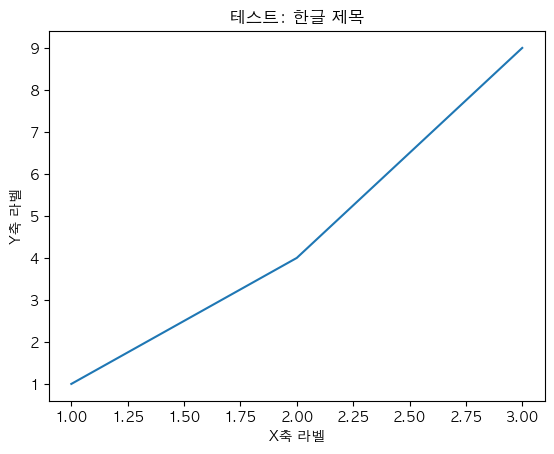

In [21]:
import matplotlib.pyplot as plt

# 1) 한글 폰트 설정
plt.rc('font', family='AppleGothic')

# 2) 마이너스(-) 기호가 깨지는 걸 방지
plt.rcParams['axes.unicode_minus'] = False

# 3) 테스트
plt.plot([1,2,3], [1,4,9])
plt.title('테스트: 한글 제목')
plt.xlabel('X축 라벨')
plt.ylabel('Y축 라벨')
plt.show()


/var/folders/34/nfsz0w6s5rl3lqtq7z6j5p_h0000gp/T/ipykernel_24657/3310446493.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


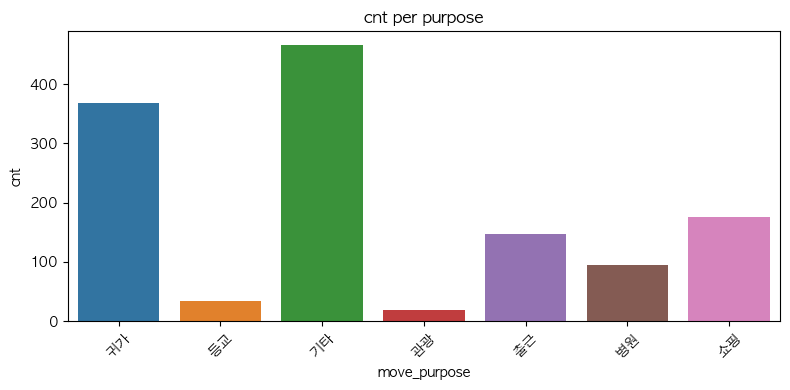

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
sns.barplot(
    data=pdf,
    x='MOVE_PURPOSE',
    y='avg_cnt',
    estimator='mean',   # 목적별 avg_cnt 의 평균
    ci=None
)
plt.title('cnt per purpose')
plt.ylabel('cnt')
plt.xlabel('move_purpose')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



In [24]:
# 상위 10개 행정동(전체 목적 통합 평균기준)
top10 = (
    pdf
    .groupby('FULL_NM')['avg_cnt']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)
print(top10)

# 하위 10개
bottom10 = (
    pdf
    .groupby('FULL_NM')['avg_cnt']
    .mean()
    .sort_values(ascending=False)
    .tail(10)
)

print(bottom10)


FULL_NM
서울특별시_강남구_역삼1동           1725.655200
서울특별시_영등포구_여의동           1682.154885
인천광역시_중구_운서동             1371.826141
서울특별시_종로구_종로1.2.3.4가동    1182.350291
경기도_화성시_봉담읍              1020.932556
서울특별시_서초구_서초3동           1014.419576
경기도_화성시_향남읍               916.881867
경기도_남양주시_진접읍              908.286325
서울특별시_금천구_가산동             887.697927
서울특별시_용산구_한강로동            882.411221
Name: avg_cnt, dtype: float64
FULL_NM
인천광역시_옹진군_연평면    18.491268
인천광역시_옹진군_북도면    17.632596
경기도_연천군_장남면      14.866181
경기도_연천군_왕징면      14.803472
경기도_광명시_광명1동     14.085351
인천광역시_옹진군_자월면    13.520103
인천광역시_옹진군_대청면    12.086107
경기도_광명시_하안4동     11.129086
경기도_연천군_중면        8.983905
인천광역시_강화군_서도면     7.273261
Name: avg_cnt, dtype: float64


In [25]:
# 행정동 × 목적 pivot
pivot = pdf.pivot_table(
    index='FULL_NM',
    columns='MOVE_PURPOSE',
    values='avg_cnt',
    aggfunc='mean'
).fillna(0)

# 상위 20개 행정동만 골라서
pivot_top20 = pivot.loc[top10.index]

import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(
    pivot_top20,
    cmap='Blues',
    linewidths=.5,
    annot=True,
    fmt='.1f'
)
plt.title('상위20 행정동의 목적별 평균 이동량')
plt.tight_layout()
plt.show()


TypeError: unstack() takes from 2 to 3 positional arguments but 4 were given